# CNN with TensorFlow and Keras

### Hardware Check

In [16]:
def get_hardware_info(use_in_notebook=True, install_packages=True):
    import platform
    system_name = platform.system()

    if install_packages:
        if system_name.lower() == "windows":
            %pip install psutil    # or: conda install psutil
            %pip install gputil
            %pip install py-cpuinfo
        elif system_name.lower() == "linux":
            !pip install psutil    # or: conda install psutil
            !pip install gputil
            !pip install py-cpuinfo

    # import needed packages
    import psutil
    import GPUtil
    from cpuinfo import get_cpu_info

    if use_in_notebook:
        if install_packages:
            if system_name.lower() == "windows":
                %pip install ipython
            elif system_name.lower() == "linux":
                !pip install ipython

        from IPython.display import clear_output
        clear_output()

    print("-"*32, "\nYour Hardware:\n")

    # General
    print("    ---> General <---")
    print("Operatingsystem:", platform.system())
    print("Version:", platform.version())
    print("Architecture:", platform.architecture())
    print("Processor:", platform.processor())

    # GPU-Information
    print("\n    ---> GPU <---")
    gpus = GPUtil.getGPUs()
    for gpu in gpus:
        print("GPU Name:", gpu.name)
        print("VRAM Total:", gpu.memoryTotal, "MB")
        print("VRAM Used:", gpu.memoryUsed, "MB")
        print("Utilization:", gpu.load * 100, "%")

    # CPU-Information
    print("\n    ---> CPU <---")
    cpu_info = get_cpu_info()
    print("CPU-Name:", cpu_info["brand_raw"])
    print("CPU Kernels:", psutil.cpu_count(logical=False))
    print("Logical CPU-Kernels:", psutil.cpu_count(logical=True))
    print("CPU-Frequence:", psutil.cpu_freq().max, "MHz")
    print("CPU-Utilization:", psutil.cpu_percent(interval=1), "%")

    # RAM-Information
    print("\n    ---> RAM <---")
    ram = psutil.virtual_memory()
    print("RAM Total:", ram.total // (1024**3), "GB")
    print("RAM Available:", ram.available // (1024**3), "GB")
    print("RAM-Utilization:", ram.percent, "%")

    print(f"\n{'-'*32}")


get_hardware_info()

-------------------------------- 
Your Hardware:

    ---> General <---
Operatingsystem: Linux
Version: #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024
Architecture: ('64bit', 'ELF')
Processor: x86_64

    ---> GPU <---
GPU Name: Tesla T4
VRAM Total: 15360.0 MB
VRAM Used: 106.0 MB
Utilization: 0.0 %

    ---> CPU <---
CPU-Name: Intel(R) Xeon(R) CPU @ 2.20GHz
CPU Kernels: 1
Logical CPU-Kernels: 2
CPU-Frequence: 0.0 MHz
CPU-Utilization: 2.5 %

    ---> RAM <---
RAM Total: 12 GB
RAM Available: 10 GB
RAM-Utilization: 19.9 %

--------------------------------


### Data Loading

Using the CIFAR-10 Dataset. An image dataset with 10 classes with 60.000 images with size: 32 x 32 pixel. Each pixel can have a value between 0-255 for r, g amd b channel.

In [17]:
import numpy as np
from tensorflow.keras import datasets, utils

(X_train, y_train), (X_test, y_test) = datasets.cifar10.load_data()

NUM_CLASSES = 10
MAX_PIXEL_VALUE = 255.0

# scaling between 0 - 1, and adjust dtype for scaling
X_train = X_train.astype("float32")/MAX_PIXEL_VALUE
X_test = X_test.astype("float32")/MAX_PIXEL_VALUE

# one-hot-encoding of target/labels to categories
y_train = utils.to_categorical(y_train, NUM_CLASSES)
y_test = utils.to_categorical(y_test, NUM_CLASSES)


X_train[54, 12, 13, 1]

0.36862746

### Build CNN Model

In [18]:
from tensorflow.keras import layers, models

input_layer = layers.Input(shape=(32, 32, 3))
conv_layer_1 = layers.Conv2D(
    filters=10,    # will results in 2 channels of the output
    kernel_size=(4, 4),
    strides=2,    # step size
    padding="same"    # pads the input data with zeros that it outputs the same shape (if stride=1)
)(input_layer)   # output if padding="same": (batch-size, height/stride, width/stride, filters)
conv_layer_2 = layers.Conv2D(
    filters=20,
    kernel_size=(3, 3),
    strides=2,
    padding="same"
)(conv_layer_1)
flatten_layer = layers.Flatten()(conv_layer_2)
output_layer = layers.Dense(units=10, activation='softmax')(flatten_layer)

model = models.Model(input_layer, output_layer)

In [19]:
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)           │ (None, 32, 32, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 16, 16, 10)          │             490 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 8, 8, 20)            │           1,820 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 10)                  │          12,810 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 15,120 (59.06 KB)

 Trainable params: 15,120 (59.06 KB)

 Non-trainable params: 0 (0.00 B)

In [20]:
# (kernel-size*input_channels + bias) *output-channels
(4*4*3 + 1) * 10

490

To calculate the parameters of a CNN we need just he previous channels, kernel-size and output-channels.

To calculate the parameters of a dense layer we need the previous output-size and the output-size.


> Remember, every unit have one bias to learn and add!

In [21]:
(3*3*10 + 1) * 20

1820

In [22]:
(1280 +1) * 10

12810

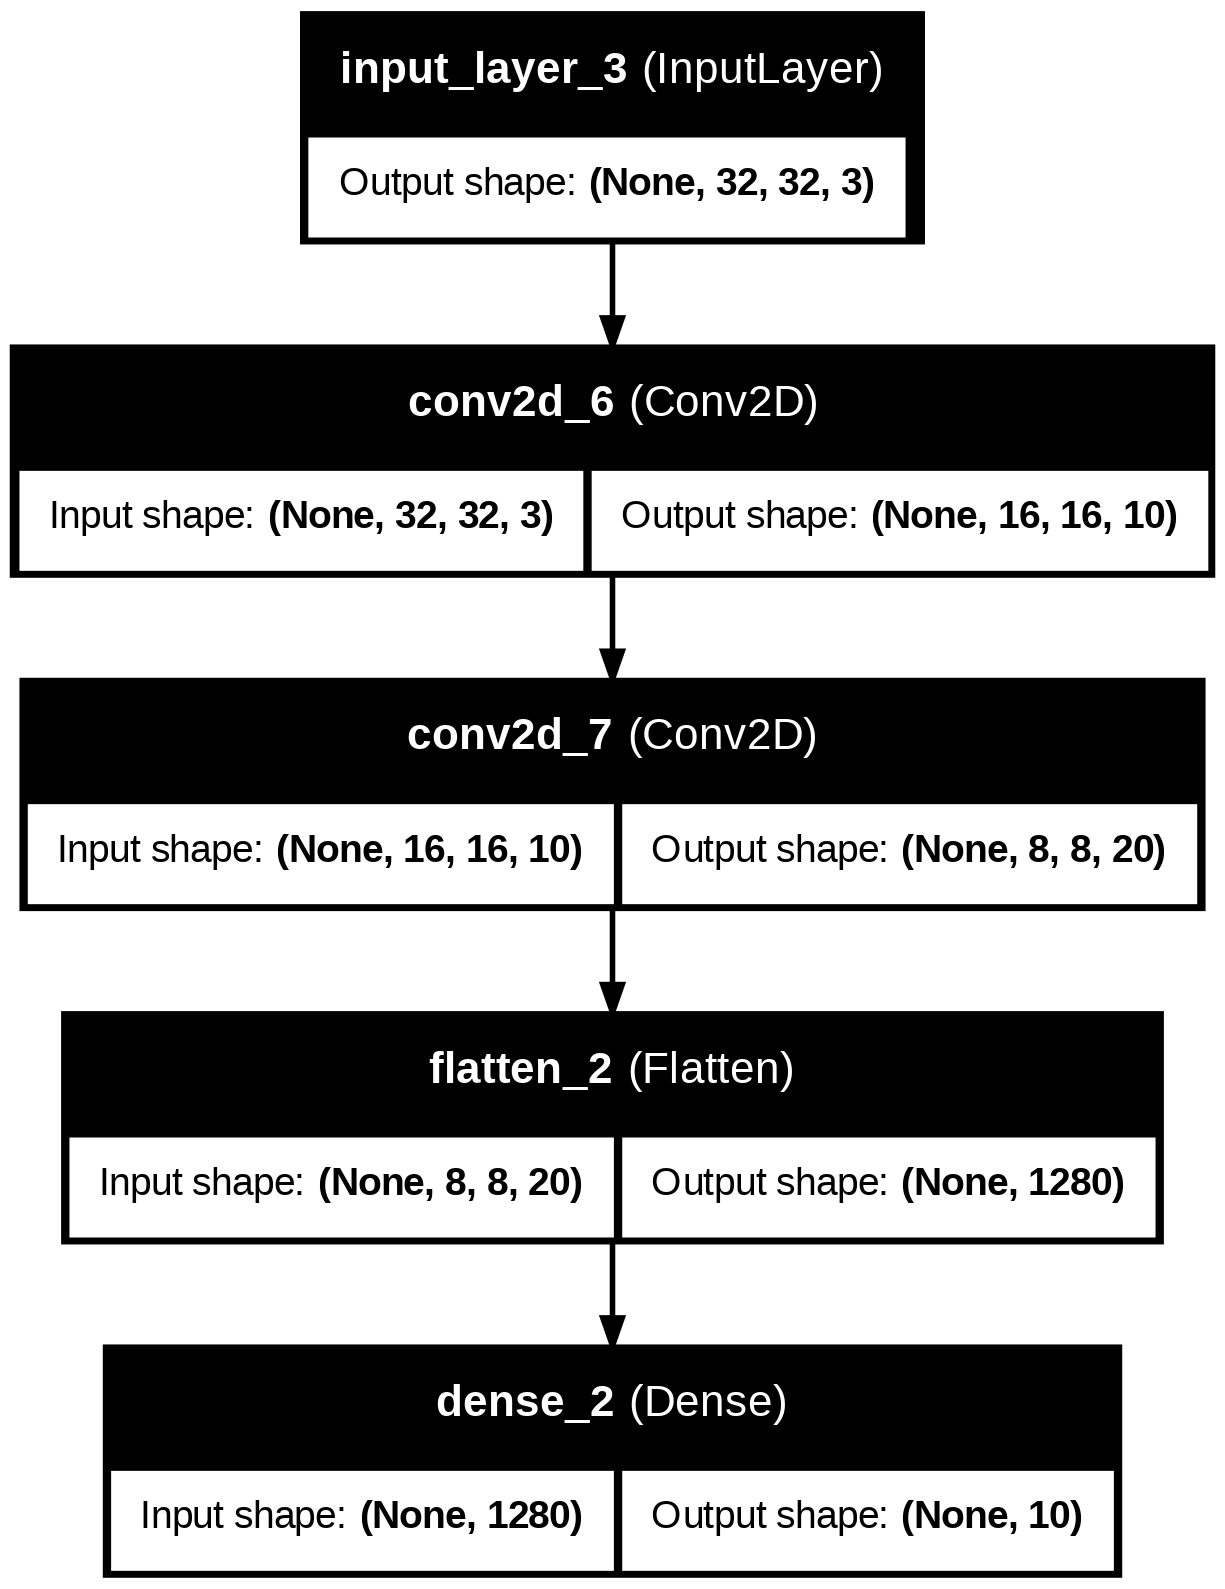

In [23]:
from tensorflow.keras.utils import plot_model

plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

In [24]:
from tensorflow.keras import layers, models

input_layer = layers.Input(shape=(32, 32, 3))

x = layers.Conv2D(
    filters=32,    # will results in 2 channels of the output
    kernel_size=(3,3),
    strides=1,    # step size
    padding="same"    # pads the input data with zeros that it outputs the same shape (if stride=1)
)(input_layer)   # output if padding="same": (batch-size, height/stride, width/stride, filters)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)

x = layers.Conv2D(
    filters=32,
    kernel_size=(3,3),
    strides=2,
    padding="same"
)(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)

x = layers.Conv2D(
    filters=64,
    kernel_size=(3,3),
    strides=1,
    padding="same"
)(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)

x = layers.Conv2D(
    filters=64,
    kernel_size=(3,3),
    strides=2,
    padding="same"
)(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)

x = layers.Flatten()(x)

x = layers.Dense(128)(x)
x = layers.BatchNormalization()(x)    # regularization against overfitting and exploding gradients
x = layers.LeakyReLU()(x)
x = layers.Dropout(rate=0.5)(x)    # regularization against overfitting

output_layer = layers.Dense(units=10, activation='softmax')(x)

model = models.Model(input_layer, output_layer)

In [32]:
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)           │ (None, 32, 32, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 32, 32, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 32, 32, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu (LeakyReLU)              │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 16, 16, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 16, 16, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_1 (LeakyReLU)            │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 16, 16, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 16, 16, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_2 (LeakyReLU)            │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 8, 8, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 8, 8, 64)            │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_3 (LeakyReLU)            │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 4096)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 128)                 │         524,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_4 (LeakyReLU)            │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 10)                  │           1,2

 Total params: 1,776,384 (6.78 MB)

 Trainable params: 591,914 (2.26 MB)

 Non-trainable params: 640 (2.50 KB)

 Optimizer params: 1,183,830 (4.52 MB)

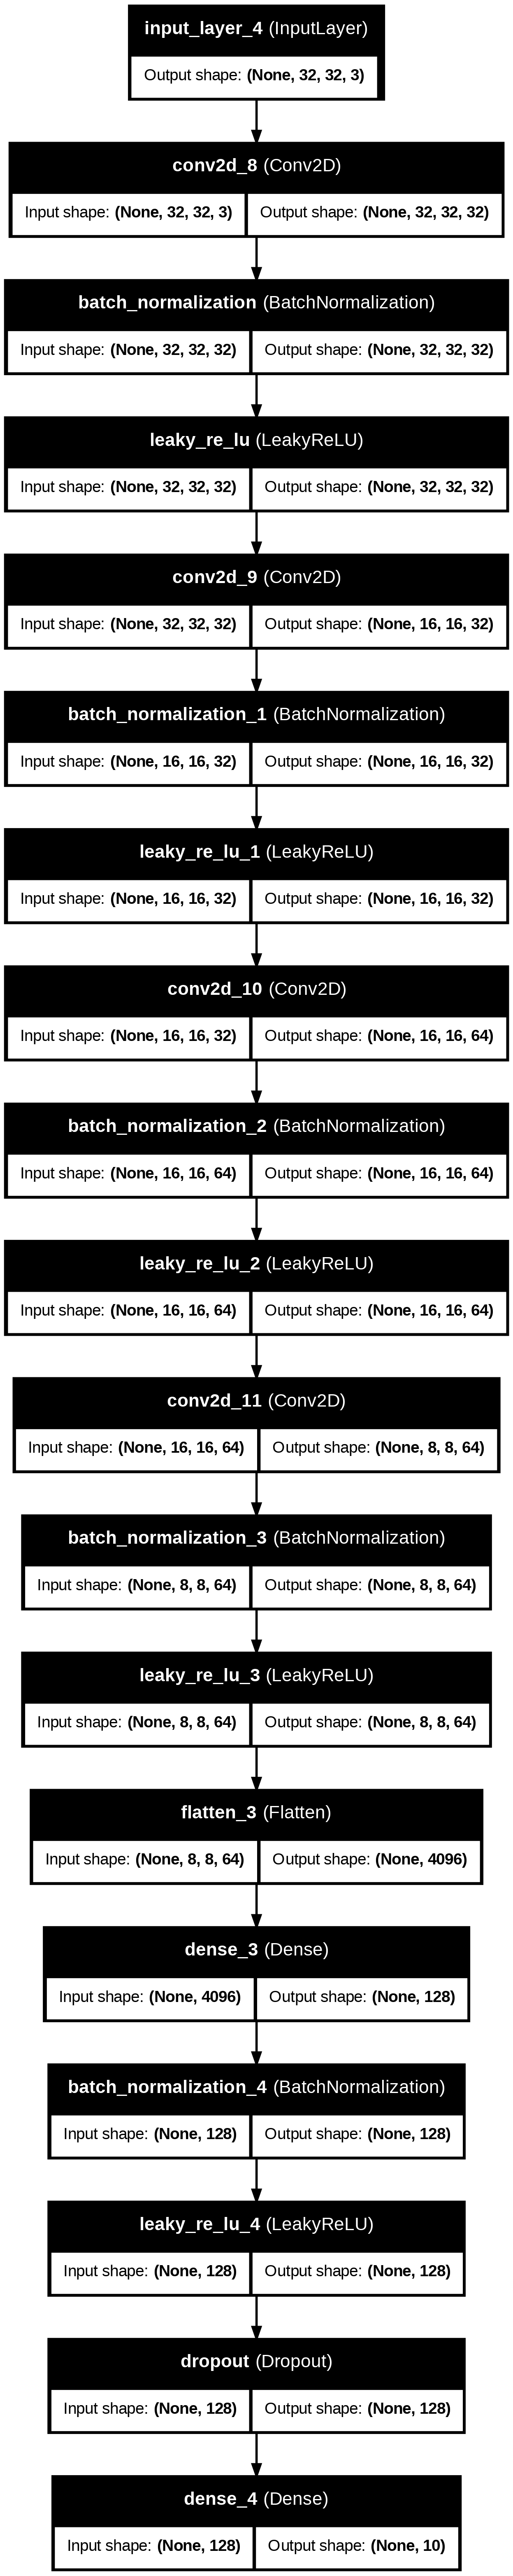

In [33]:
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

### Train the Model

- compile/create the model with an optimizer (learning-startegy) and a loss function
- train the model

In [26]:
from tensorflow.keras import optimizers

# 5e-4 = 5 * 10^-4
optimizer = optimizers.Adam(learning_rate=5e-4)
model.compile(
    loss="categorical_crossentropy",
    optimizer=optimizer,
    metrics=['accuracy']
)

model.fit(
    X_train,
    y_train,
    batch_size=32,
    epochs=10,
    shuffle=True
)

Epoch 1/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 22s 6ms/step - accuracy: 0.3913 - loss: 1.7860
Epoch 2/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.5811 - loss: 1.1835
Epoch 3/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.6445 - loss: 1.0003
Epoch 4/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.6783 - loss: 0.9183
Epoch 5/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.7091 - loss: 0.8348
Epoch 6/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - accuracy: 0.7222 - loss: 0.7977
Epoch 7/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.7374 - loss: 0.7519
Epoch 8/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.7481 - loss: 0.7146
Epoch 9/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.7698 - loss: 0.6569
Epoch 10/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.7750 - loss: 0.6360


In [27]:
get_hardware_info(install_packages=False)

-------------------------------- 
Your Hardware:

    ---> General <---
Operatingsystem: Linux
Version: #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024
Architecture: ('64bit', 'ELF')
Processor: x86_64

    ---> GPU <---
GPU Name: Tesla T4
VRAM Total: 15360.0 MB
VRAM Used: 1158.0 MB
Utilization: 19.0 %

    ---> CPU <---
CPU-Name: Intel(R) Xeon(R) CPU @ 2.20GHz
CPU Kernels: 1
Logical CPU-Kernels: 2
CPU-Frequence: 0.0 MHz
CPU-Utilization: 11.6 %

    ---> RAM <---
RAM Total: 12 GB
RAM Available: 9 GB
RAM-Utilization: 23.0 %

--------------------------------


### Evaluation

The evaluation function gives a list of metrics. First it outputs the loss then (in this case) the accuracy.

In [28]:
model.evaluate(X_test, y_test)

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6721 - loss: 0.9851


[0.9916612505912781, 0.6693999767303467]

### Inferencing the Model (Predicting)

In [29]:
CLASSES = np.array(['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'])

predictions = model.predict(X_test)
ground_truth = CLASSES[np.argmax(y_test, axis=-1)]
print("Predictions as probabilities: ", predictions)
print("\nPredictions as most probably: ", np.argmax(predictions, axis=-1))
print("\nPredictions as most probably class: ", CLASSES[np.argmax(predictions, axis=-1)])
predictions = CLASSES[np.argmax(predictions, axis=-1)]

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
Predictions as probabilities:  [[5.76750783e-04 1.65238234e-04 1.70697900e-03 ... 1.58125367e-05
  1.49730548e-01 8.91928270e-04]
 [1.26552559e-03 9.72183123e-02 1.72739249e-07 ... 7.90093491e-10
  9.01266575e-01 2.49258563e-04]
 [3.10561836e-01 1.22696675e-01 1.22018915e-03 ... 4.32220811e-04
  5.54971397e-01 8.39812588e-03]
 ...
 [6.24501627e-05 5.74936053e-07 6.36558756e-02 ... 1.74771085e-01
  1.83186436e-04 4.32049019e-05]
 [1.51088029e-01 1.09172642e-01 2.19070818e-03 ... 2.78342719e-04
  1.87166428e-04 6.34265540e-04]
 [3.11483950e-06 1.95166285e-06 2.29004957e-03 ... 8.15968215e-01
  2.66035590e-06 1.45581816e-06]]

Predictions as most probably:  [3 8 8 ... 5 4 7]

Predictions as most probably class:  ['cat' 'ship' 'ship' ... 'dog' 'deer' 'horse']


In [30]:
# passing an nparray uses the elements as single index each -> so the previous code works
CLASSES[np.array([0, 1, 2, 3])]

array(['airplane', 'automobile', 'bird', 'cat'], dtype='<U10')

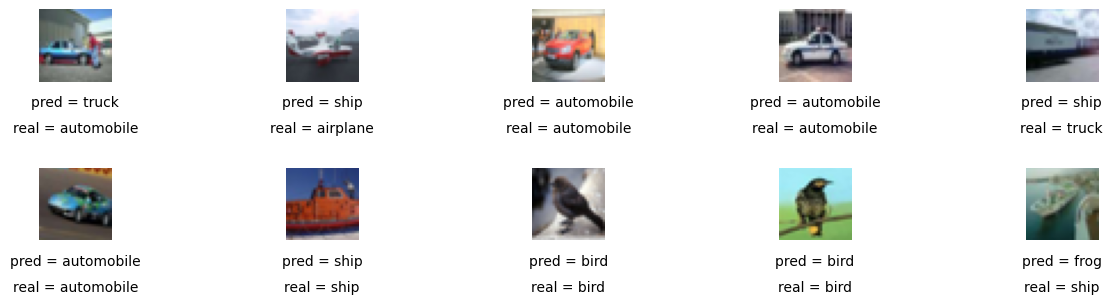

In [31]:
import matplotlib.pyplot as plt

images_to_show = 10
image_idxs = np.random.choice(range(len(X_test)), images_to_show)

rows = 2
cols = images_to_show // rows + (images_to_show % rows > 0)

fig, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(15, 3))
fig.subplots_adjust(hspace=1.2, wspace=0.4)
ax = ax.ravel()    # ax.flatten()

for i, cur_idx in enumerate(image_idxs):
    cur_image = X_test[cur_idx]
    ax[i].axis('off')
    ax[i].text(0.5, -0.35, f"pred = {predictions[cur_idx]}", fontsize=10, ha='center', transform=ax[i].transAxes)
    ax[i].text(0.5, -0.7, f"real = {ground_truth[cur_idx]}", fontsize=10, ha='center', transform=ax[i].transAxes)
    ax[i].imshow(cur_image)

plt.show();